# Rede Neural Convolucional


In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Carregar os datasets

transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train = DataLoader(dataset=dataset_train, shuffle=True, batch_size=200)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=1000)
test, validation = [], []

for index, element in enumerate(test_loader):
  if index/len(test_loader) < 0.49:
    test.append(element)
  else:
    validation.append(element)

test_size, validation_size = len(test) * 1000, len(validation) * 1000
print(test_size, validation_size)

5000 5000


In [5]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(p=0.5)
        self.cn_dropout = nn.Dropout2d(p=0.2)
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3)
        self.conv3_bn = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32*5*5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        
    def forward(self, x):
        x = self.cn_dropout(self.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(x)
        
        x = self.cn_dropout(self.relu(self.conv2_bn(self.conv2(x))))
        x = self.cn_dropout(self.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(x)
        
        x = x.view(-1, 32*5*5)
        
        x = self.fc_dropout(self.relu(self.fc1(x)))
        x = self.fc_dropout(self.relu(self.fc2(x)))
        x = self.fc_dropout(self.relu(self.fc3(x)))
        return x

In [6]:
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss().cuda()

print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc_dropout): Dropout(p=0.5)
  (cn_dropout): Dropout2d(p=0.2)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [7]:
import sys
import copy

def one_hot(results):
    results = results.cpu().detach().numpy().tolist()
    return results.index(max(results))

def train_model(model, epochs, train, test):
    global test_size
    best_model, train_losses, test_acc = model, [], []
    min_error = sys.float_info.max
    
    train_inputs, train_labels = [], []
    for _, (inputs, labels) in enumerate(train):
        train_inputs.append(inputs.to(device))
        train_labels.append(labels.to(device))
    
    test_inputs, test_labels = [], []
    for _, (inputs, labels) in enumerate(test):
        test_inputs.append(inputs.to(device))
        test_labels.append(labels.to(device))
    
    for epoch in range(epochs):
        # Training Set
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(zip(train_inputs, train_labels), 0):
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / (50000/200))
        
        # Test set
        model.eval()
        hits = 0
        for i, (inputs, labels) in enumerate(zip(test_inputs, test_labels), 0):
            y_pred = model(inputs)
            for i, (pred, label) in enumerate(zip(y_pred, labels)):
                if one_hot(pred)==label.item():
                    hits+=1
                    
        test_acc.append(hits / test_size * 100)
        if test_acc[-1] <= min_error:
            min_error = test_acc[-1]
            best_model = copy.deepcopy(model)

        print("Loss at epoch ["+ str(epoch + 1) +"]: "+ str(train_losses[-1]) +" (Train Set)")
        print("Accuracy at epoch [" + str(epoch + 1) + "]:"+str(test_acc[-1])+"% (Test Set)")
        print('\n')    
            
    return best_model, train_losses, test_acc

# Trainamento do Modelo


In [8]:
# Treinamento por 400 Épocas
best_model, train_losses, test_acc = train_model(model, 400, train, test)

Loss at epoch [1]: 2.304200301170349 (Train Set)
Accuracy at epoch [1]:17.64% (Test Set)


Loss at epoch [2]: 2.298341275215149 (Train Set)
Accuracy at epoch [2]:21.32% (Test Set)


Loss at epoch [3]: 2.2897805490493774 (Train Set)
Accuracy at epoch [3]:25.1% (Test Set)


Loss at epoch [4]: 2.269992081642151 (Train Set)
Accuracy at epoch [4]:28.999999999999996% (Test Set)


Loss at epoch [5]: 2.24306596660614 (Train Set)
Accuracy at epoch [5]:32.26% (Test Set)


Loss at epoch [6]: 2.2253772716522215 (Train Set)
Accuracy at epoch [6]:33.32% (Test Set)


Loss at epoch [7]: 2.2093800201416016 (Train Set)
Accuracy at epoch [7]:33.98% (Test Set)


Loss at epoch [8]: 2.196049430847168 (Train Set)
Accuracy at epoch [8]:36.34% (Test Set)


Loss at epoch [9]: 2.1797677478790285 (Train Set)
Accuracy at epoch [9]:37.84% (Test Set)


Loss at epoch [10]: 2.1715503187179563 (Train Set)
Accuracy at epoch [10]:39.519999999999996% (Test Set)


Loss at epoch [11]: 2.157576295852661 (Train Set)
Accuracy 

Loss at epoch [85]: 1.8645293455123901 (Train Set)
Accuracy at epoch [85]:63.18% (Test Set)


Loss at epoch [86]: 1.8698242015838622 (Train Set)
Accuracy at epoch [86]:62.739999999999995% (Test Set)


Loss at epoch [87]: 1.8654077382087708 (Train Set)
Accuracy at epoch [87]:63.38% (Test Set)


Loss at epoch [88]: 1.8686196656227112 (Train Set)
Accuracy at epoch [88]:63.54% (Test Set)


Loss at epoch [89]: 1.8641448392868043 (Train Set)
Accuracy at epoch [89]:62.86000000000001% (Test Set)


Loss at epoch [90]: 1.8588122205734252 (Train Set)
Accuracy at epoch [90]:63.580000000000005% (Test Set)


Loss at epoch [91]: 1.8569966650009155 (Train Set)
Accuracy at epoch [91]:64.4% (Test Set)


Loss at epoch [92]: 1.8438950595855712 (Train Set)
Accuracy at epoch [92]:64.60000000000001% (Test Set)


Loss at epoch [93]: 1.8549888281822204 (Train Set)
Accuracy at epoch [93]:64.18% (Test Set)


Loss at epoch [94]: 1.8555562686920166 (Train Set)
Accuracy at epoch [94]:64.88000000000001% (Test Set)



Loss at epoch [169]: 1.7511504397392272 (Train Set)
Accuracy at epoch [169]:70.54% (Test Set)


Loss at epoch [170]: 1.7497923130989075 (Train Set)
Accuracy at epoch [170]:70.28% (Test Set)


Loss at epoch [171]: 1.7413305802345276 (Train Set)
Accuracy at epoch [171]:68.86% (Test Set)


Loss at epoch [172]: 1.740158772468567 (Train Set)
Accuracy at epoch [172]:70.82000000000001% (Test Set)


Loss at epoch [173]: 1.7464600200653075 (Train Set)
Accuracy at epoch [173]:70.89999999999999% (Test Set)


Loss at epoch [174]: 1.7368574390411378 (Train Set)
Accuracy at epoch [174]:70.74000000000001% (Test Set)


Loss at epoch [175]: 1.7333353996276855 (Train Set)
Accuracy at epoch [175]:69.89999999999999% (Test Set)


Loss at epoch [176]: 1.7453439178466796 (Train Set)
Accuracy at epoch [176]:70.19999999999999% (Test Set)


Loss at epoch [177]: 1.7340793223381044 (Train Set)
Accuracy at epoch [177]:71.16% (Test Set)


Loss at epoch [178]: 1.7374999713897705 (Train Set)
Accuracy at epoch [178]:7

Loss at epoch [252]: 1.6757820525169373 (Train Set)
Accuracy at epoch [252]:74.74% (Test Set)


Loss at epoch [253]: 1.677974048614502 (Train Set)
Accuracy at epoch [253]:75.03999999999999% (Test Set)


Loss at epoch [254]: 1.672878727912903 (Train Set)
Accuracy at epoch [254]:74.76% (Test Set)


Loss at epoch [255]: 1.6687656908035278 (Train Set)
Accuracy at epoch [255]:74.92% (Test Set)


Loss at epoch [256]: 1.6739274339675903 (Train Set)
Accuracy at epoch [256]:74.96000000000001% (Test Set)


Loss at epoch [257]: 1.6649606127738952 (Train Set)
Accuracy at epoch [257]:74.76% (Test Set)


Loss at epoch [258]: 1.6644905681610107 (Train Set)
Accuracy at epoch [258]:74.64% (Test Set)


Loss at epoch [259]: 1.6783056325912475 (Train Set)
Accuracy at epoch [259]:74.92% (Test Set)


Loss at epoch [260]: 1.6666743307113647 (Train Set)
Accuracy at epoch [260]:74.64% (Test Set)


Loss at epoch [261]: 1.6557825136184692 (Train Set)
Accuracy at epoch [261]:75.2% (Test Set)


Loss at epoch [262]

Loss at epoch [336]: 1.6214860849380492 (Train Set)
Accuracy at epoch [336]:76.46% (Test Set)


Loss at epoch [337]: 1.6281073713302612 (Train Set)
Accuracy at epoch [337]:76.36% (Test Set)


Loss at epoch [338]: 1.625630509376526 (Train Set)
Accuracy at epoch [338]:76.22% (Test Set)


Loss at epoch [339]: 1.6156368951797486 (Train Set)
Accuracy at epoch [339]:76.22% (Test Set)


Loss at epoch [340]: 1.6183114776611327 (Train Set)
Accuracy at epoch [340]:76.25999999999999% (Test Set)


Loss at epoch [341]: 1.6230465083122254 (Train Set)
Accuracy at epoch [341]:76.8% (Test Set)


Loss at epoch [342]: 1.6314069242477418 (Train Set)
Accuracy at epoch [342]:76.7% (Test Set)


Loss at epoch [343]: 1.6164336967468262 (Train Set)
Accuracy at epoch [343]:75.84% (Test Set)


Loss at epoch [344]: 1.6142237277030944 (Train Set)
Accuracy at epoch [344]:76.6% (Test Set)


Loss at epoch [345]: 1.6145085010528564 (Train Set)
Accuracy at epoch [345]:76.6% (Test Set)


Loss at epoch [346]: 1.6171094560

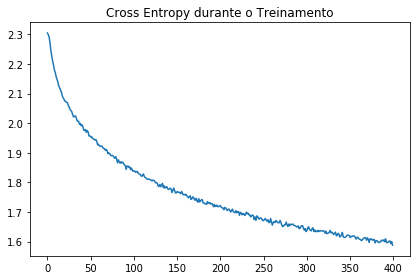

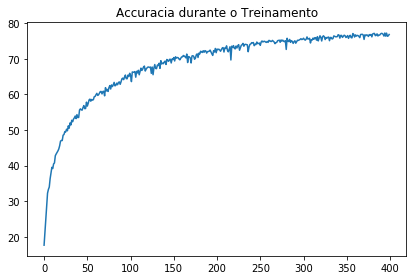

In [9]:
import matplotlib.pyplot as plt
plt.title("Cross Entropy durante o Treinamento")
plt.tight_layout()
_ = plt.plot(train_losses)
plt.show()

plt.title("Accuracia durante o Treinamento")
plt.tight_layout()
_ = plt.plot(test_acc)
plt.show()

In [10]:
def evaluate(model, dataset, batch_size):
  inputs_list, labels_list = [], []
  for _, (inputs, labels) in enumerate(dataset):
      inputs_list.append(inputs.to(device))
      labels_list.append(labels.to(device))
    
  hits = 0
  for i, (inputs, labels) in enumerate(zip(inputs_list, labels_list), 0):
      y_pred = model(inputs)
      for i, (pred, label) in enumerate(zip(y_pred, labels)):
          if one_hot(pred)==label.item():
              hits+=1
  return hits / (len(dataset) * batch_size) * 100

# Avaliação do Modelo no dataset de Treino

In [11]:
print(evaluate(model, train, 200))

85.824


# Avaliação do Modelo no dataset de teste

In [12]:
print(evaluate(model, test, 1000))

76.86


# Validação do Modelo (conjunto de validação)

In [13]:
print(evaluate(model, validation, 1000))

76.3
